In [8]:
import os

# os.system("1_get_waveforms.py")

In [9]:
# os.system("2_mseed2sac.py")

In [10]:
cwd = os.getcwd()

# os.system(f"python3 {cwd}/3_convert_hyperinverse_to_hash_phase.py")


In [11]:
# os.system(f"python3 {cwd}/4_DiTingMotion_on_ridgecrest.py")

In [12]:
# os.system("5_convert_to_hashpy_station.py")

In [13]:
# os.system("6_runhash.py")

In [14]:
######### packages #########
import obspy
from obspy import read, UTCDateTime, Stream
import numpy as np
import pandas as pd
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt

######### system #########
import os
import sys
import argparse as ap

# cut data path
# sys.path.insert(0, './cut/2019070404031.48') # add parent directory to path

# input files
args_m = './models/DiTingMotionJul.hdf5'
evdir = '../../data/eq_data/all_data'
phasenet_picks = '../../data/eq_data/all_data/phasenet_files/phasenet_phasepick_datetime.csv'
# mseed files list
mseed_list = [fname for fname in os.listdir(evdir) if fname.endswith('.mseed')]
print(mseed_list[0])

nc71993336.mseed


In [15]:
motion_model =tf.keras.models.load_model(args_m,compile=False)
phasenet_df = pd.read_csv(phasenet_picks, parse_dates=['begin_time','phase_time'])
# select only phase_type = 'P', and phase_score > 0.75
phasenet_df = phasenet_df[(phasenet_df.phase_type == 'P') & (phasenet_df.phase_score > 0.75)].reset_index(drop=True)
phasenet_df = phasenet_df[phasenet_df.file_name == mseed_list[0]]
sel_ev = phasenet_df[0:1]
print(sel_ev.station_id[0])
sel_ev

BK.GASB.00.HH


,station_id,begin_time,phase_index,phase_time,phase_score,phase_type,file_name,phase_amplitude,phase_amp
0,BK.GASB.00.HH,2013-05-17 23:14:24.840,4039,2013-05-17 23:15:05.230,0.799,P,nc71993336.mseed,1459.634521,1459.634521


BK.GASB.00.HHZ BK.GASB.00.HH


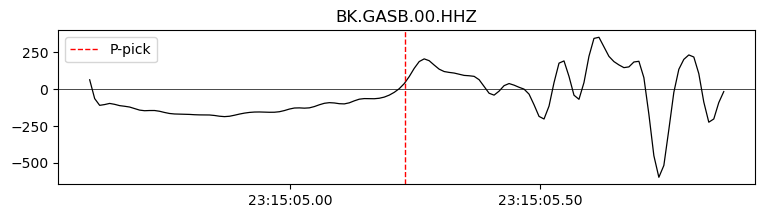

In [115]:
import matplotlib.dates as mdates

p_pick = UTCDateTime(phasenet_df.phase_time[0])
st = read(evdir + '/' + mseed_list[0])

# Find the relevant trace
for tr in st:
    if tr.id == sel_ev.station_id[0]+'Z' and tr.stats.channel[-1] == 'Z':
        t_st = tr.copy()                    # Make a copy of the trace
        t_st.detrend('demean')              # Remove mean
        try:
            t_st.detrend(type='linear')     # Remove trend if possible
        except:
            t_st.detrend(type='constant')   # Remove trend if linear fails
        t_st = t_st.taper(0.001)            # Apply a taper
        t_st = t_st.slice(p_pick - 0.63, p_pick + 0.64)                              # Cut the trace around the P-pick for 128 samples
        t_st.filter('bandpass', freqmin=0.5, freqmax=20, corners=4, zerophase=True)  # Apply a bandpass filter
        break  # Exit the loop once you find the trace


# Generate time axis 
times = np.arange(t_st.stats.starttime, t_st.stats.endtime + t_st.stats.delta, t_st.stats.delta)

# Convert to matplotlib's numerical dates 
times = mdates.date2num(times)

# Plot the trace
fig, ax = plt.subplots(1, 1, figsize=(9, 2))
ax.plot(times, t_st.data, 'k', lw=0.9)
ax.set_title(f"{t_st.id}")

# Format x-axis ticks
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S.%f'))
ax.xaxis.set_major_locator(mdates.MicrosecondLocator(interval=5e5))

# round x labels to 2 decimal places
ax.set_xticks(ax.get_xticks()[1:-1:1]) # start, stop, step
ax.set_xticklabels([mdates.num2date(x).strftime('%H:%M:%S.%f')[:-4] for x in ax.get_xticks()])


# Add the pick time (assuming p_pick is a UTCDateTime object)
p_pick_mpl = mdates.date2num(p_pick)  # Convert to matplotlib format
ax.axvline(p_pick_mpl, color='r', linestyle='--', linewidth=1, label='P-pick')
ax.axhline(0, color='k', ls='-', linewidth=0.5)
ax.legend()


plt.show()

In [116]:
motion_input = np.zeros([1, 128, 2]) # 1 trace, 128 samples, 2 components
if len(t_st) == len(motion_input[0, :, 0]):
    motion_input[0, :, 0] = t_st.data[0:128] # Z component 

In [117]:

# normalize the data by subtracting the mean and dividing by the standard deviation
if np.max(motion_input[0, :, 0]) == 0: # if the maximum value is 0, then the data is empty
        pass
else:
        motion_input[0, :, 0] -= np.mean(motion_input[0, :, 0]) # subtract the mean to center the data around 0
        norm_factor = np.std(motion_input[0, :, 0]) # calculate the standard deviation

        if norm_factor == 0: # if the standard deviation is 0, then the data is empty
            pass
        else:
            motion_input[0, :, 0] /= norm_factor # divide by the standard deviation to normalize the data
            diff_data = np.diff(motion_input[0, 64:, 0])
            diff_sign_data = np.sign(diff_data)
            motion_input[0, 65:, 1] = diff_sign_data[:]
            


In [118]:
pred_res = motion_model.predict(motion_input)
pred_fmp = (pred_res['T0D0'] + pred_res['T0D1'] + pred_res['T0D2'] + pred_res['T0D3']) / 4
pred_cla = (pred_res['T1D0'] + pred_res['T1D1'] + pred_res['T1D2'] + pred_res['T1D3']) / 4

# print(pred_fmp, pred_cla)

print(pred_fmp[0, :])
print(np.argmax(pred_fmp[0, :]))

1/1 [==============================] - 1s 672ms/step
[0.9760827  0.01105797 0.00133237]
0


In [119]:

"""
if the 1st index is the maximum, then the polarity is UP/positive (+1)
or, if the 2nd index is the maximum, then the polarity is DOWN/negative (-1)
otherwise, the polarity is x [the 3rd index is the maximum, undecided (0/x)]
"""
if np.argmax(pred_fmp[0, :]) == 1:    
    polarity = 'D'

elif np.argmax(pred_fmp[0, :]) == 0:
    polarity = 'U'

else:
    polarity = 'x'

print(polarity)

U
